# HW1 布尔查询之BSBI与索引压缩

本次作业使用斯坦福大学[CS 276 / LING 286: Information Retrieval and Web Search](https://web.stanford.edu/class/cs276/)课程的代码框架来实现。具体来说主要包含的内容有：
1. [索引构建 (40%)](#索引构建与检索-(40%)) 使用BSBI方法模拟在内存不足的情况下的索引构建方式，并应用于布尔查询
2. [索引压缩 (30%)](#索引压缩-(30%)) 使用可变长编码对构建的索引进行压缩
3. [布尔检索 (10%)](#布尔联合检索-(10%)) 对空格分隔的单词查询进行联合（与）布尔检索
3. [实验报告 (10%)](#Report-(25%)) 描述你的代码并回答一些问题
4. [额外的编码方式 (10%)](#额外的编码方式-(10%)) 鼓励使用额外的编码方式对索引进行压缩 (例如, gamma-encoding)

In [31]:
# You can add additional imports here
import sys
import pickle as pkl
import array
import os
import timeit
import contextlib

# 数据集

实验使用的文本数据是stanford.edu域下的网页内容，可从http://web.stanford.edu/class/cs276/pa/pa1-data.zip 下载。以下代码将大约170MB的文本数据下载到当前目录下，

In [32]:
import urllib.request
import zipfile

# data_url = 'http://web.stanford.edu/class/cs276/pa/pa1-data.zip'
# data_dir = 'pa1-data'
# urllib.request.urlretrieve(data_url, data_dir+'.zip')
# zip_ref = zipfile.ZipFile(data_dir+'.zip', 'r')
# zip_ref.extractall()
# zip_ref.close()

之后构建的索引会被存储到`output_dir`，`tmp`会存储测试数据（toy-data）所生成的一些临时文件

In [33]:
try: 
    os.mkdir('output_dir')
except FileExistsError:
    pass
try: 
    os.mkdir('tmp')
except FileExistsError:
    pass
try: 
    os.mkdir('toy_output_dir')
except FileExistsError:
    pass

在数据目录下有10个子目录（命名0-9）

In [34]:
sorted(os.listdir('pa1-data'))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

每一个子目录下的文件都包含一个独立网页的内容。可以认为在同一子目录下没有同名文件，即每个文件的绝对路径不会相同。

In [35]:
sorted(os.listdir('pa1-data/0'))[:10]

['3dradiology.stanford.edu_',
 '3dradiology.stanford.edu_patient_care_Case%2520studies_AVM.html',
 '3dradiology.stanford.edu_patient_care_case_studies.html',
 '5-sure.stanford.edu_',
 '50years.stanford.edu_',
 'a3cservices.stanford.edu_awards_nominate_',
 'a3cservices.stanford.edu_facilities_',
 'a3cservices.stanford.edu_lead_',
 'aa.stanford.edu_',
 'aa.stanford.edu_about_aviation.php']

所有的网页内容已经经过处理，仅包含由空格分隔开的单词，不再需要进行额外的标准化工作。

In [36]:
with open('pa1-data/0/3dradiology.stanford.edu_', 'r') as f:
    print(f.read())

3d radiology lab stanford university school of medicine stanford school of medicine 3d and quantitative imaging in the department of radiology search this site only stanford medical sites ways to give find a person alumni lane library ways to give find a person about us mission to develop and apply innovative techniques for efficient quantitative analysis and display of medical imaging data through interdisciplinary collaboration goals education to train physicians and technologists locally and worldwide in the latest developments in 3d and quantitative imaging research to develop new approaches to the exploration analysis and quantitative assesment of diagnostic images that result in a new and or more cost effective diagnostic approaches and b new techniques for the design and planning and monitoring of therapy patient care to deliver valid clinically relevant visualization and analysis of medical imaging data to the stanford community locations richard m lucas magnetic resonance imag

In [37]:
toy_dir = 'toy-data'

# 索引构建与检索 (40%)

作业的第一部分是使用**blocked sort-based indexing (BSBI)** 算法来构建倒排索引并实现布尔检索。关于BSBI算法可以参考老师课件或者斯坦福教材[Section 4.2](http://nlp.stanford.edu/IR-book/pdf/04const.pdf)。以下摘自教材内容

> To construct an index, we first make a pass through the collection assembling all term-docID pairs. We then sort the pairs with the term as the dominant key and docID as the secondary key. Finally, we organize the docIDs for each term into a postings list and compute statistics like term and document frequency. For small collections, all this can be done in memory. 

对于无法在内存一次性处理的较大数据集，将会使用到二级存储（如：磁盘）。

## IdMap (6%)

再次引用教材 Section 4.2:

> To make index construction more efficient, we represent terms as termIDs (instead of strings), where each termID is a unique serial number. We can build the mapping from terms to termIDs on the fly while we are processing the collection. Similarly, we also represent documents as docIDs (instead of strings).

我们首先定义一个辅助类`IdMap`，用于将字符串和数字ID进行相互映射，以满足我们在term和termID、doc和docID间转换的需求。

实现以下代码中的`_get_str` 和 `_get_id`函数，IdMap类的唯一接口是`__getitem__`，它是一个特殊函数，重写了下标运算`[]`,根据下标运算键的类型得到正确的映射值（如果不存在需要添加）。（特殊函数可参考[官方文档](https://docs.python.org/3.7/reference/datamodel.html#special-method-names)）
<br>
<br>
我们会用到字典来将字符串转换为数字，用列表来将数字转换为字符串。(4%)

In [38]:
class IdMap:
    """Helper class to store a mapping from strings to ids."""
    def __init__(self):
        self.str_to_id = {}
        self.id_to_str = []
        
    def __len__(self):
        """Return number of terms stored in the IdMap"""
        return len(self.id_to_str)
        
    def _get_str(self, i):
        """Returns the string corresponding to a given id (`i`)."""
        ### Begin your code
        # 防止负数索引和越界访问
        if i < 0 or i >= len(self.id_to_str):
            raise IndexError(f"ID {i} is out of range")
        # 直接通过列表索引实现O(1)查找
        return self.id_to_str[i]
        ### End your code
        
    def _get_id(self, s):
        """Returns the id corresponding to a string (`s`). 
        If `s` is not in the IdMap yet, then assigns a new id and returns the new id.
        """
        ### Begin your code
        # 处理新字符串的自动注册
        if s not in self.str_to_id:
            # 使用当前长度作为新ID，保证严格递增
            new_index = len(self.id_to_str)
            self.str_to_id[s] = new_index
            self.id_to_str.append(s)
        return self.str_to_id[s]
        ### End your code
            
    def __getitem__(self, key):
        """If `key` is a integer, use _get_str; 
           If `key` is a string, use _get_id;"""
        if type(key) is int:
            return self._get_str(key)
        elif type(key) is str:
            return self._get_id(key)
        else:
            raise TypeError

确保代码能通过以下简单测试样例 (2%)

In [39]:
testIdMap = IdMap()
assert testIdMap['a'] == 0, "Unable to add a new string to the IdMap"
assert testIdMap['bcd'] == 1, "Unable to add a new string to the IdMap"
assert testIdMap['a'] == 0, "Unable to retrieve the id of an existing string"
assert testIdMap[1] == 'bcd', "Unable to retrive the string corresponding to a\
                                given id"
try:
    testIdMap[2]
except IndexError as e:
    assert True, "Doesn't throw an IndexError for out of range numeric ids"
assert len(testIdMap) == 2

这两段代码设计思路围绕着实现字符串与ID的双向映射展开。

第一段代码用于通过ID查找对应的字符串。首先进行边界检查，防止负数索引和越界访问，若出现这种情况就抛出索引错误，以保证程序的健壮性。之后利用列表的随机访问特性，通过索引直接查找对应的字符串，实现了O(1)的时间复杂度，保证查找效率。

第二段代码用于根据字符串查找对应的ID。当遇到新字符串时，会自动为其注册一个新ID。通过使用列表的当前长度作为新ID，保证了ID的严格递增。随后将新字符串及其ID分别存入字典和列表中，以实现双向映射，最后返回该字符串对应的ID。 

之后会需要你自己来写测试样例来确保你的程序正常运行

## 将倒排列表编码成字节数组 (2%)

为了高效地从磁盘读写倒排列表（文档ID），我们将其存储为字节数组的形式。代码提供了`UncompressedPostings`类来用静态函数实现对倒排列表的编码和解码。在之后的任务中你需要使用该接口实现索引压缩版本（可变长编码）。

参考:
1. https://docs.python.org/3/library/array.html
2. https://pymotw.com/3/array/#module-array

In [40]:
class UncompressedPostings:
    
    @staticmethod
    def encode(postings_list):
        """Encodes postings_list into a stream of bytes
        
        Parameters
        ----------
        postings_list: List[int]
            List of docIDs (postings)
            
        Returns
        -------
        bytes
            bytearray representing integers in the postings_list
        """
        return array.array('L', postings_list).tobytes()
        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes postings_list from a stream of bytes
        
        Parameters
        ----------
        encoded_postings_list: bytes
            bytearray representing encoded postings list as output by encode 
            function
            
        Returns
        -------
        List[int]
            Decoded list of docIDs from encoded_postings_list
        """
        
        decoded_postings_list = array.array('L')
        decoded_postings_list.frombytes(encoded_postings_list)
        return decoded_postings_list.tolist()

运行以下代码查看其工作方式 (2%)

In [41]:
x = UncompressedPostings.encode([1,2,3])
print(x)
print(UncompressedPostings.decode(x))

b'\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00'
[1, 2, 3]


## 磁盘上的倒排索引 (2%)

> With main memory insufficient, we need to use an external sorting algorithm, that is, one that uses disk. For acceptable speed, the central requirement of such an algorithm is that it minimize the number of random disk seeks during sorting - sequential disk reads are far faster than seeks. 

在这一部分我们提供了一个基类`InvertedIndex`，之后会在此基础上构建它的子类`InvertedIndexWriter`, `InvertedIndexIterator` 和 `InvertedIndexMapper`。在Python中我们常用`cPickle`进行序列化，但是它并不支持部分读和部分写，无法满足BSBI算法的需要，所以我们需要定义自己的存储方式。

In [42]:
class InvertedIndex:
    """A class that implements efficient reads and writes of an inverted index 
    to disk
    
    Attributes
    ----------
    postings_dict: Dictionary mapping: termID->(start_position_in_index_file, 
                                                number_of_postings_in_list,
                                               length_in_bytes_of_postings_list)
        This is a dictionary that maps from termIDs to a 3-tuple of metadata 
        that is helpful in reading and writing the postings in the index file 
        to/from disk. This mapping is supposed to be kept in memory. 
        start_position_in_index_file is the position (in bytes) of the postings 
        list in the index file
        number_of_postings_in_list is the number of postings (docIDs) in the 
        postings list
        length_in_bytes_of_postings_list is the length of the byte 
        encoding of the postings list
    
    terms: List[int]
        A list of termIDs to remember the order in which terms and their 
        postings lists were added to index. 
        
        After Python 3.7 we technically no longer need it because a Python dict 
        is an OrderedDict, but since it is a relatively new feature, we still
        maintain backward compatibility with a list to keep track of order of 
        insertion. 
    """
    def __init__(self, index_name, postings_encoding=None, directory=''):
        """
        Parameters
        ----------
        index_name (str): Name used to store files related to the index
        postings_encoding: A class implementing static methods for encoding and 
            decoding lists of integers. Default is None, which gets replaced
            with UncompressedPostings
        directory (str): Directory where the index files will be stored
        """

        self.index_file_path = os.path.join(directory, index_name+'.index')
        self.metadata_file_path = os.path.join(directory, index_name+'.dict')

        if postings_encoding is None:
            self.postings_encoding = UncompressedPostings
        else:
            self.postings_encoding = postings_encoding
        self.directory = directory

        self.postings_dict = {}
        self.terms = []         #Need to keep track of the order in which the 
                                #terms were inserted. Would be unnecessary 
                                #from Python 3.7 onwards

    def __enter__(self):
        """Opens the index_file and loads metadata upon entering the context"""
        # Open the index file
        self.index_file = open(self.index_file_path, 'rb+')

        # Load the postings dict and terms from the metadata file
        with open(self.metadata_file_path, 'rb') as f:
            self.postings_dict, self.terms = pkl.load(f)
            self.term_iter = self.terms.__iter__()                       

        return self
    
    def __exit__(self, exception_type, exception_value, traceback):
        """Closes the index_file and saves metadata upon exiting the context"""
        # Close the index file
        self.index_file.close()
        
        # Write the postings dict and terms to the metadata file
        with open(self.metadata_file_path, 'wb') as f:
            pkl.dump([self.postings_dict, self.terms], f)

因为是在与磁盘上的文件进行交互，所以我们提供了`__enter__`和`__exit__`函数，它使得我们能够像使用python中文件IO一样使用`with`语句。（参考[上下文管理器官方文档](https://docs.python.org/3/library/contextlib.html)）

以下是使用 `InvertedIndexWriter` 上下文管理器的实例: (2%)

```python
with InvertedIndexWriter('test', directory='tmp/') as index:
    # Some code here
```

## 索引 (30%)

> BSBI (i) segments the collection into parts of equal size, (ii) sorts the termID-docID pairs of each part in memory, (iii) stores intermediate sorted results on disk, and (iv) merges all intermediate results into the final index. 

你需要将每一个子目录当做一个块（block），并且在构建索引的过程中每次只能加载一个块（模拟内存不足）。注意到我们是将操作系统意义上的块进行了抽象。你可以认为每个块足够小，能被装载进内存。

在这一部分，我们将阶段性地构造类`BSBIIndex`。函数`index`给出了BSBI算法的框架，而你的工作则是在接下来的部分中实现函数`parse_block`, `invert_write` 和 `merge`。

In [43]:
# Do not make any changes here, they will be overwritten while grading
class BSBIIndex:
    """ 
    Attributes
    ----------
    term_id_map(IdMap): For mapping terms to termIDs
    doc_id_map(IdMap): For mapping relative paths of documents (eg 
        0/3dradiology.stanford.edu_) to docIDs
    data_dir(str): Path to data
    output_dir(str): Path to output index files
    index_name(str): Name assigned to index
    postings_encoding: Encoding used for storing the postings.
        The default (None) implies UncompressedPostings
    """
    def __init__(self, data_dir, output_dir, index_name = "BSBI", 
                 postings_encoding = None):
        self.term_id_map = IdMap()
        self.doc_id_map = IdMap()
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.index_name = index_name
        self.postings_encoding = postings_encoding

        # Stores names of intermediate indices
        self.intermediate_indices = []
        
    def save(self):
        """Dumps doc_id_map and term_id_map into output directory"""
        
        with open(os.path.join(self.output_dir, 'terms.dict'), 'wb') as f:
            pkl.dump(self.term_id_map, f)
        with open(os.path.join(self.output_dir, 'docs.dict'), 'wb') as f:
            pkl.dump(self.doc_id_map, f)
    
    def load(self):
        """Loads doc_id_map and term_id_map from output directory"""
        
        with open(os.path.join(self.output_dir, 'terms.dict'), 'rb') as f:
            self.term_id_map = pkl.load(f)
        with open(os.path.join(self.output_dir, 'docs.dict'), 'rb') as f:
            self.doc_id_map = pkl.load(f)
            
    def index(self):
        """Base indexing code
        
        This function loops through the data directories, 
        calls parse_block to parse the documents
        calls invert_write, which inverts each block and writes to a new index
        then saves the id maps and calls merge on the intermediate indices
        """
        for block_dir_relative in sorted(next(os.walk(self.data_dir))[1]):
            td_pairs = self.parse_block(block_dir_relative)
            index_id = 'index_'+block_dir_relative
            self.intermediate_indices.append(index_id)
            with InvertedIndexWriter(index_id, directory=self.output_dir, 
                                     postings_encoding=
                                     self.postings_encoding) as index:
                self.invert_write(td_pairs, index)
                td_pairs = None
        self.save()
        with InvertedIndexWriter(self.index_name, directory=self.output_dir, 
                                 postings_encoding=
                                 self.postings_encoding) as merged_index:
            with contextlib.ExitStack() as stack:
                indices = [stack.enter_context(
                    InvertedIndexIterator(index_id, 
                                          directory=self.output_dir, 
                                          postings_encoding=
                                          self.postings_encoding)) 
                 for index_id in self.intermediate_indices]
                self.merge(indices, merged_index)

### 解析 (10%)

> The function `parse_block`  parses documents into termID-docID pairs and accumulates the pairs in memory until a block of a fixed size is full. We choose the block size to fit comfortably into memory to permit a fast in-memory sort. 

你需要将每一个子目录当做一个块，`parse_block`接收子目录路径作为参数。同一子目录下所有文件名都是不同的。 (5%)

_注意 - 我们使用 `BSBIIndex` 继承 `BSBIIndex`, 这只是对一个已存在类添加新内容的简单方法。在这里只是用来切分类的定义（jupyter notebook内教学使用，无特殊含义）。_

In [44]:
class BSBIIndex(BSBIIndex):            
    def parse_block(self, block_dir_relative):
        """Parses a tokenized text file into termID-docID pairs
        
        Parameters
        ----------
        block_dir_relative : str
            Relative Path to the directory that contains the files for the block
        
        Returns
        -------
        List[Tuple[Int, Int]]
            Returns all the td_pairs extracted from the block
        
        Should use self.term_id_map and self.doc_id_map to get termIDs and docIDs.
        These persist across calls to parse_block
        """
        ### Begin your code
        # 保持相对路径结构确保跨平台兼容性
        curr_dir = os.path.join(self.data_dir, block_dir_relative)

        # 获取当前目录下的所有文件并排序
        file_list = sorted(os.listdir(curr_dir))
          
        td_pairs = []
        for file_name in file_list:
            # 保留目录结构信息作为文档标识
            doc_id = self.doc_id_map[os.path.join(block_dir_relative, file_name)]  # 获取doc_id
            with open(os.path.join(curr_dir, file_name), 'r') as f:
                content = f.read()
            file_words = content.split()  
            # 先收集当前文件的pair再整体extend
            # 比直接append到td_pairs减少扩容次数
            temp_list = []
            for word in file_words:
                temp = (self.term_id_map[word], doc_id)  
                temp_list.append(temp)
            td_pairs.extend(temp_list)  # 将该文件的td_pairs加入到最终列表中
        return td_pairs
        ### End your code

在该段代码设计中，主要目的是从指定目录读取文件内容并构建词项 - 文档对列表。为保证跨平台兼容性，使用 `os.path.join` 函数拼接路径以维持相对路径结构，避免因不同操作系统路径分隔符差异产生问题。接着获取该目录下所有文件并排序，确保后续处理顺序一致。遍历文件列表时，先从 `self.doc_id_map` 中获取以文件相对路径为键对应的文档 ID，保证文档 ID 唯一性。打开文件读取内容并按空格分割成单词列表，对每个单词从 `self.term_id_map` 中获取其词项 ID，将词项 ID 和文档 ID 组成元组暂存于 `temp_list` 中，最后用 `extend` 方法把 `temp_list` 里的元组添加到最终的 `td_pairs` 列表，减少列表扩容次数以提升性能，最终返回包含所有文件词项 - 文档对的列表。 

观察函数在测试数据上是否正常运行 (2%)

In [45]:
with open('toy-data/0/fine.txt', 'r') as f:
    print(f.read())
with open('toy-data/0/hello.txt', 'r') as f:
    print(f.read())

i'm fine , thank you

hi hi
how are you ?



In [46]:
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'tmp/', index_name = 'toy')
BSBI_instance.parse_block('0')

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (4, 1),
 (8, 1)]

写一些测试样例来确保`parse_block`方法正常运行（如：相同单词出现时是相同ID） (3%)

In [47]:
### Begin your code
import os
import shutil

# 创建测试目录和文件的辅助函数
def create_test_files(directory, files_content):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for filename, content in files_content.items():
        with open(os.path.join(directory, filename), 'w') as f:
            f.write(content)

# 测试样例1：单个文件测试
def test_single_file():
    test_data_dir = 'test_single'
    files_content = {
        'doc1.txt': 'apple banana apple\norange banana'
    }
    create_test_files(test_data_dir, files_content)
    
    # 初始化索引器实例
    BSBI_instance = BSBIIndex(data_dir='.', output_dir='tmp/', index_name='test_index')
    BSBI_instance.term_id_map = IdMap() 
    BSBI_instance.doc_id_map = IdMap()
    doc_id = BSBI_instance.doc_id_map._get_id(os.path.join(test_data_dir, 'doc1.txt'))

    # 调用 parse_block 方法,预注册文档路径（测试ID生成逻辑）
    td_pairs = BSBI_instance.parse_block(test_data_dir)
    print("Test Single File - Parsed termID-docID pairs:", td_pairs)
    
    # 预期结果：[(0, 0), (1, 0), (0, 0), (2, 0), (1, 0)]
    expected_pairs = [(0, 0), (1, 0), (0, 0), (2, 0), (1, 0)]
    assert td_pairs == expected_pairs, f"Failed: {td_pairs} != {expected_pairs}"
    
    shutil.rmtree(test_data_dir)

# 测试样例2：多个文件测试
def test_multiple_files():
    test_data_dir = 'test_multiple'
    files_content = {
        'doc1.txt': 'apple banana apple\norange banana',
        'doc2.txt': 'apple apple orange\norange banana'
    }
    create_test_files(test_data_dir, files_content)
    
    BSBI_instance = BSBIIndex(data_dir='.', output_dir='tmp/', index_name='test_index')
    BSBI_instance.term_id_map = IdMap()
    BSBI_instance.doc_id_map = IdMap()

    # 验证文档ID分配顺序
    doc_id1 = BSBI_instance.doc_id_map._get_id(os.path.join(test_data_dir, 'doc1.txt'))
    doc_id2 = BSBI_instance.doc_id_map._get_id(os.path.join(test_data_dir, 'doc2.txt'))

    # 调用 parse_block 方法
    td_pairs = BSBI_instance.parse_block(test_data_dir)
    print("Test Multiple Files - Parsed termID-docID pairs:", td_pairs)
    
    # 预期结果：
    expected_pairs = [
        (0, doc_id1), (1, doc_id1), (0, doc_id1), (2, doc_id1), (1, doc_id1),
        (0, doc_id2), (0, doc_id2), (2, doc_id2), (2, doc_id2), (1, doc_id2)
    ]
    assert td_pairs == expected_pairs, f"Failed: {td_pairs} != {expected_pairs}"
    
    shutil.rmtree(test_data_dir)

# 测试样例3：空文件测试
def test_empty_file():
    test_data_dir = 'test_empty'
    files_content = {
        'empty.txt': ''
    }
    create_test_files(test_data_dir, files_content)
    
    BSBI_instance = BSBIIndex(data_dir='.', output_dir='tmp/', index_name='test_index')
    BSBI_instance.term_id_map = IdMap()
    BSBI_instance.doc_id_map = IdMap()
    doc_id = BSBI_instance.doc_id_map._get_id(os.path.join(test_data_dir, 'empty.txt'))

    # 调用 parse_block 方法
    td_pairs = BSBI_instance.parse_block(test_data_dir)
    print("Test Empty File - Parsed termID-docID pairs:", td_pairs)
    
    expected_pairs = []
    assert td_pairs == expected_pairs, f"Failed: {td_pairs} != {expected_pairs}"
    
    shutil.rmtree(test_data_dir)

# # 测试样例4：特殊字符测试
# def test_special_characters():
#     test_data_dir = 'test_special'
#     files_content = {
#         'special.txt': 'Apple, apple; BANANA! apple.\nOrAnGe? banana...'
#     }
#     create_test_files(test_data_dir, files_content)
    
#     BSBI_instance = BSBIIndex(data_dir='.', output_dir='tmp/', index_name='test_index')
#     BSBI_instance.term_id_map = IdMap()
#     BSBI_instance.doc_id_map = IdMap()
#     doc_id = BSBI_instance.doc_id_map._get_id(os.path.join(test_data_dir, 'special.txt'))

#     # 调用 parse_block 方法
#     td_pairs = BSBI_instance.parse_block(test_data_dir)
#     print("Test Special Characters - Parsed termID-docID pairs:", td_pairs)
    
#     # 检查是否正确处理了大小写和标点符号
#     expected_pairs = [(0, doc_id), (0, doc_id), (1, doc_id), (0, doc_id), (2, doc_id), (1, doc_id)]
#     assert td_pairs == expected_pairs, f"Failed: {td_pairs} != {expected_pairs}"
    
#     shutil.rmtree(test_data_dir)

# 运行所有测试
test_single_file()
test_multiple_files()
test_empty_file()
# test_special_characters()

print("All tests passed!")
print("简单测试：")
#简单测试
for item in BSBI_instance.term_id_map.str_to_id.items():
    print(item)
for item in BSBI_instance.doc_id_map.str_to_id.items():
    print(item)
### End your code

Test Single File - Parsed termID-docID pairs: [(0, 0), (1, 0), (0, 0), (2, 0), (1, 0)]
Test Multiple Files - Parsed termID-docID pairs: [(0, 0), (1, 0), (0, 0), (2, 0), (1, 0), (0, 1), (0, 1), (2, 1), (2, 1), (1, 1)]
Test Empty File - Parsed termID-docID pairs: []
All tests passed!
简单测试：
("i'm", 0)
('fine', 1)
(',', 2)
('thank', 3)
('you', 4)
('hi', 5)
('how', 6)
('are', 7)
('?', 8)
('0\\fine.txt', 0)
('0\\hello.txt', 1)


此代码旨在对 `BSBIIndex` 类的 `parse_block` 方法进行全面测试，以确保其在不同场景下能正确解析文件并生成词项 - 文档对。首先定义了 `create_test_files` 辅助函数，用于创建测试目录和文件，保证不同测试场景能顺利模拟，它会检查目录是否存在，不存在则创建并将内容写入相应文件。接着设置了多个测试用例，单个文件测试会创建仅含一个文件的测试目录，初始化 `BSBIIndex` 实例及映射，调用 `parse_block` 方法生成词项 - 文档对列表，与预期结果对比，不符则报错，最后删除测试目录；多个文件测试创建包含多个文件的测试目录，初始化实例和映射，验证文档 ID 分配顺序后调用方法生成列表并对比结果，不符报错后删除目录；空文件测试创建含空文件的测试目录，初始化并调用方法，期望得到空列表，不符则报错后删除目录；特殊字符测试（注释部分）创建含特殊字符文件的测试目录，初始化并调用方法，检查是否正确处理大小写和标点符号，不符报错后删除目录。代码依次运行各测试用例，所有测试通过后输出“All tests passed!”，最后进行简单测试，输出 `term_id_map` 和 `doc_id_map` 中的键值对以查看映射关系。 

### 倒排表 (10%)

> The block is then inverted and written to disk. Inversion involves two steps. First, we sort the termID-docID pairs. Next, we collect all termID-docID pairs with the same termID into a postings list, where a posting is simply a docID. The result, an inverted index for the block we have just read, is then written to disk.

在这一部分我们添加函数`invert_write`来实现由termID-docID对构建倒排表。 

但是，我们首先需要实现类`InvertedIndexWriter`。和列表类似，该类提供了append函数，但是倒排表不会存储在内存中而是直接写入到磁盘里。 (3%)

In [48]:
class InvertedIndexWriter(InvertedIndex):
    """"""
    def __enter__(self):
        self.index_file = open(self.index_file_path, 'wb+')              
        return self

    def append(self, term, postings_list):
        """Appends the term and postings_list to end of the index file.
        
        This function does three things, 
        1. Encodes the postings_list using self.postings_encoding
        2. Stores metadata in the form of self.terms and self.postings_dict
           Note that self.postings_dict maps termID to a 3 tuple of 
           (start_position_in_index_file, 
           number_of_postings_in_list, 
           length_in_bytes_of_postings_list)
        3. Appends the bytestream to the index file on disk

        Hint: You might find it helpful to read the Python I/O docs
        (https://docs.python.org/3/tutorial/inputoutput.html) for
        information about appending to the end of a file.
        
        Parameters
        ----------
        term:
            term or termID is the unique identifier for the term
        postings_list: List[Int]
            List of docIDs where the term appears
        """
        ### Begin your code
        self.terms.append(term)  # 将当前 term 加入到 terms 列表中
        encoded_postings = self.postings_encoding.encode(postings_list)  # 对 postings_list 进行编码
        start_position = self.index_file.tell()  # 获取当前文件指针位置，作为起始位置
        self.postings_dict[term] = (
            start_position,  # term 在索引文件中的起始位置
            len(postings_list),  # 该 term 出现的文档数量
            len(encoded_postings)  # 编码后的 postings_list 长度（字节）
        )
        self.index_file.write(encoded_postings)  # 将编码后的 postings_list 写入到索引文件中
        self.index_file.flush()  # 确保数据及时写入磁盘
        ### End your code

这段代码的核心功能是将当前的词项（term）及其对应的倒排表（postings_list）信息写入索引文件并记录关键信息。具体来说，代码首先把当前词项添加到 `terms` 列表里；接着使用 `postings_encoding` 对倒排表进行编码处理；然后获取当前文件指针位置，将其作为该词项倒排表在索引文件中的起始位置；之后把词项作为键，将起始位置、该词项出现的文档数量以及编码后的倒排表长度这三个信息组成的元组作为值存入 `postings_dict` 中；随后把编码后的倒排表写入索引文件；最后调用 `flush` 方法确保数据及时写入磁盘，避免数据丢失或不一致的情况。 

尽管还没有实现读取索引的类，我们还是可以用以下测试代码检测我们的实现。 (2%)

In [49]:
with InvertedIndexWriter('test', directory='tmp/') as index:
    index.append(1, [2, 3, 4])
    index.append(2, [3, 4, 5])
    index.index_file.seek(0)
    assert index.terms == [1,2], "terms sequence incorrect"
    assert index.postings_dict == {1: (0, 3, len(UncompressedPostings.encode([2,3,4]))), 
                                   2: (len(UncompressedPostings.encode([2,3,4])), 3, 
                                       len(UncompressedPostings.encode([3,4,5])))}, "postings_dict incorrect"
    assert UncompressedPostings.decode(index.index_file.read()) == [2, 3, 4, 3, 4, 5], "postings on disk incorrect"

现在我们实现 `invert_write`，它将解析得到的td_pairs转换成倒排表，并使用`InvertedIndexWriter` 类将其写入磁盘。 (3%)

In [50]:
class BSBIIndex(BSBIIndex):
    def invert_write(self, td_pairs, index):
        """Inverts td_pairs into postings_lists and writes them to the given index
        
        Parameters
        ----------
        td_pairs: List[Tuple[Int, Int]]
            List of termID-docID pairs
        index: InvertedIndexWriter
            Inverted index on disk corresponding to the block       
        """
        ### Begin your code
        # 将原始td_pairs转换为term->doclist的倒排结构
        term_dict = {}

        # 聚合处理
        for term_id, doc_id in td_pairs:
            # 使用集合实现自动去重
            if term_id not in term_dict:
                term_dict[term_id] = {doc_id}
            else:
                term_dict[term_id].add(doc_id)

        # 排序写入
        for term_id in sorted(term_dict.keys()):
            # 对文档ID列表排序，有利于压缩算法的效率
            # 集合转列表时需显式排序
            sorted_postings = sorted(term_dict[term_id])
            index.append(term_id, sorted_postings)
        ### End your code

这段代码的主要目的是将原始的词项 - 文档对（td_pairs）转换为倒排索引结构，以便后续处理。首先，代码创建了一个空字典 `term_dict` 用于存储倒排索引。接着，通过遍历 `td_pairs` 进行聚合处理，利用集合的特性自动去除重复的文档 ID，若词项 ID 不在 `term_dict` 中，则以该词项 ID 为键创建一个包含对应文档 ID 的集合；若已存在，则将新的文档 ID 添加到对应的集合中。最后，对 `term_dict` 中的键（词项 ID）进行排序，将每个词项 ID 对应的文档 ID 集合转换为排序后的列表，这样做有助于提高后续压缩算法的效率，然后将词项 ID 和排序后的文档 ID 列表添加到 `index` 中。 

我们可以在测试数据上读取一个块并观察倒排索引中包含的内容。
仿照`InvertedIndexWriter`部分写一些测试样例。 (2%)

In [51]:
from collections import defaultdict

### Begin your code
with InvertedIndexWriter('test', directory='tmp/') as index:
    # 初始化BSBI索引器实例
    # 使用测试集验证核心逻辑
    BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir='tmp/', index_name='toy')
    td_pairs = BSBI_instance.parse_block('0')
    BSBI_instance.invert_write(td_pairs, index)
    print(index.terms)
    print(index.postings_dict)

print("其他——（“索引”部分相同验证）")

def compute_postings_list(td_pairs):
    postings_dict = defaultdict(list)
    for term_id, doc_id in td_pairs:
        if doc_id not in postings_dict[term_id]:
            postings_dict[term_id].append(doc_id)
    # 将每个 postings_list 排序
    for term_id in postings_dict:
        postings_dict[term_id].sort()
    return postings_dict

# 在 'tmp/' 目录中创建测试的 InvertedIndexWriter 实例
with InvertedIndexWriter('test_index', directory='tmp/') as index:
    # 创建 BSBIIndex 实例，指定数据目录和输出目录
    BSBI_instance = BSBIIndex(data_dir='toy-data', output_dir='tmp/', index_name='toy')

    # 使用 parse_block 方法解析 '0' 号数据块，生成 termID-docID 对
    td_pairs = BSBI_instance.parse_block('0')

    # 打印解析得到的 td_pairs
    print("TermID-DocID Pairs (td_pairs):")
    for term_id, doc_id in td_pairs:
        print(f"Term ID: {term_id}, Doc ID: {doc_id}")

    # 计算 td_pairs 中每个 termID 的 postings_list
    expected_postings = compute_postings_list(td_pairs)

    # 打印预期的 postings_list
    print("\nExpected Postings Lists:")
    for term_id, postings_list in expected_postings.items():
        print(f"Term ID {term_id}: Postings List: {postings_list}")

    # 调用 invert_write 方法，将 termID-docID 对写入倒排索引
    BSBI_instance.invert_write(td_pairs, index)

    # 打印已写入索引文件中的词项列表
    print("\nTerms in Index:", index.terms)

    # 打印倒排表的元数据字典 (termID -> (start_position, doc_count, byte_length))
    print("\nPostings Dictionary:")
    for term_id, (start, count, length) in index.postings_dict.items():
        print(f"Term ID {term_id}: Start={start}, Count={count}, Length={length}")
        
        # 验证 doc_count 是否正确
        expected_count = len(expected_postings[term_id])
        assert count == expected_count, f"Doc count mismatch for Term ID {term_id}: {count} != {expected_count}"
        
        # 验证倒排列表内容是否一致
        # 对比实际写入的倒排列表和预期列表的长度
        encoded_postings = index.postings_encoding.encode(expected_postings[term_id])
        assert length == len(encoded_postings), f"Byte length mismatch for Term ID {term_id}: {length} != {len(encoded_postings)}"
### End your code

[0, 1, 2, 3, 4, 5, 6, 7, 8]
{0: (0, 1, 4), 1: (4, 1, 4), 2: (8, 1, 4), 3: (12, 1, 4), 4: (16, 2, 8), 5: (24, 1, 4), 6: (28, 1, 4), 7: (32, 1, 4), 8: (36, 1, 4)}
其他——（“索引”部分相同验证）
TermID-DocID Pairs (td_pairs):
Term ID: 0, Doc ID: 0
Term ID: 1, Doc ID: 0
Term ID: 2, Doc ID: 0
Term ID: 3, Doc ID: 0
Term ID: 4, Doc ID: 0
Term ID: 5, Doc ID: 1
Term ID: 5, Doc ID: 1
Term ID: 6, Doc ID: 1
Term ID: 7, Doc ID: 1
Term ID: 4, Doc ID: 1
Term ID: 8, Doc ID: 1

Expected Postings Lists:
Term ID 0: Postings List: [0]
Term ID 1: Postings List: [0]
Term ID 2: Postings List: [0]
Term ID 3: Postings List: [0]
Term ID 4: Postings List: [0, 1]
Term ID 5: Postings List: [1]
Term ID 6: Postings List: [1]
Term ID 7: Postings List: [1]
Term ID 8: Postings List: [1]

Terms in Index: [0, 1, 2, 3, 4, 5, 6, 7, 8]

Postings Dictionary:
Term ID 0: Start=0, Count=1, Length=4
Term ID 1: Start=4, Count=1, Length=4
Term ID 2: Start=8, Count=1, Length=4
Term ID 3: Start=12, Count=1, Length=4
Term ID 4: Start=16, Count=2, 

这段代码主要围绕使用 `BSBIIndex` 类和 `InvertedIndexWriter` 类来构建和验证倒排索引展开。首先，通过 `InvertedIndexWriter` 初始化一个索引实例，同时初始化 `BSBIIndex` 实例并调用 `parse_block` 方法获取词项 - 文档对（`td_pairs`），再调用 `invert_write` 方法将这些对写入索引，并打印索引的词项和倒排表元数据。接着定义了 `compute_postings_list` 函数，用于计算预期的倒排列表。之后再次创建 `InvertedIndexWriter` 和 `BSBIIndex` 实例，重新获取 `td_pairs` 并打印，计算预期的倒排列表并打印。然后调用 `invert_write` 方法写入索引，打印索引中的词项列表和倒排表元数据。最后进行验证，检查每个词项的文档数量和倒排列表的字节长度是否与预期一致，若不一致则抛出断言错误。 

### 合并 (10%)
> The algorithm simultaneously merges the ten blocks into one large merged index. To do the merging, we open all block files simultaneously, and maintain small read buffers for the ten blocks we are reading and a write buffer for the final merged index we are writing. 

Python中的迭代模型非常自然地符合我们维护一个小的读缓存的要求。我们可以迭代地从磁盘上每次读取文件的一个倒排列表。我们通过构建`InvertedIndex`的子类`InvertedIndexIterator`来完成这个迭代任务。 (3%)

In [52]:
class InvertedIndexIterator(InvertedIndex):
    """"""
    def __enter__(self):
        """Adds an initialization_hook to the __enter__ function of super class
        """
        super().__enter__()
        self._initialization_hook()
        return self

    def _initialization_hook(self):
        """Use this function to initialize the iterator
        """
        ### Begin your code
        self.curr_pos = 0  # 初始化当前位置指针为 0
        ### End your code

    def __iter__(self): 
        return self
    
    def __next__(self):
        """Returns the next (term, postings_list) pair in the index.
        
        Note: This function should only read a small amount of data from the 
        index file. In particular, you should not try to maintain the full 
        index file in memory.
        """
        ### Begin your code
        if self.curr_pos < len(self.terms):
            # 获取当前 term，依赖terms预排序特性
            term = self.terms[self.curr_pos] 
            # 获取 term 对应的元数据
            start, num, length = self.postings_dict[term] 
             # 定位文件指针到起始位置
            self.index_file.seek(start)  
            # 读取编码后的倒排列表，读取指定字节长度的编码数据
            encoded_postings_list = self.index_file.read(length)  
            # 解码倒排列表，解码过程需与编码器严格匹配
            postings_list = self.postings_encoding.decode(encoded_postings_list)  
            # 移动当前位置指针，指针移动必须在成功解码之后
            self.curr_pos += 1  
            # 返回 term 和对应的 postings_list
            return term, postings_list  
        else:
            raise StopIteration  # 如果所有条目已遍历完，抛出 StopIteration 异常
        ### End your code

    def delete_from_disk(self):
        """Marks the index for deletion upon exit. Useful for temporary indices
        """
        self.delete_upon_exit = True

    def __exit__(self, exception_type, exception_value, traceback):
        """Delete the index file upon exiting the context along with the
        functions of the super class __exit__ function"""
        self.index_file.close()
        if hasattr(self, 'delete_upon_exit') and self.delete_upon_exit:
            os.remove(self.index_file_path)
            os.remove(self.metadata_file_path)
        else:
            with open(self.metadata_file_path, 'wb') as f:
                pkl.dump([self.postings_dict, self.terms], f)

这段代码是一个迭代器方法，主要用于按顺序从倒排索引中获取词项（term）及其对应的倒排列表（postings_list）。首先，检查当前位置指针 `self.curr_pos` 是否小于 `self.terms` 的长度，以判断是否还有未遍历的词项。若条件满足，利用 `self.terms` 预排序的特性获取当前位置的词项 `term` ，并从 `self.postings_dict` 中获取该词项对应的元数据，包括在索引文件中的起始位置 `start` 、出现的文档数量 `num` 以及编码后的倒排列表长度 `length` 。然后，将索引文件的指针定位到起始位置，读取指定长度的编码数据作为编码后的倒排列表 `encoded_postings_list` ，并使用 `self.postings_encoding` 进行解码得到实际的倒排列表 `postings_list` 。在确保解码成功后，将当前位置指针 `self.curr_pos` 后移一位，最后返回当前词项 `term` 和对应的倒排列表 `postings_list` 。若当前位置指针已达到或超过 `self.terms` 的长度，说明所有条目已遍历完，则抛出 `StopIteration` 异常，结束迭代。 

为了测试以上代码，我们先用`InvertedIndexWriter` 创建索引，然后再迭代遍历。写一些小的测试样例观察它是否正常运行。至少你得写一个测试，手工构建一个小的索引，用`InvertedIndexWriter`将他们写入磁盘，然后用`InvertedIndexIterator`迭代遍历倒排索引。 (2%)

In [53]:
### Begin your code
with InvertedIndexWriter('test', directory='tmp/') as index:
    BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'tmp/', index_name = 'toy')
    td_pairs= BSBI_instance.parse_block('0')
    print(td_pairs)
    BSBI_instance.invert_write(td_pairs, index)
with InvertedIndexIterator('test', directory='tmp/') as index_iter:
    for line in index_iter:
        print(line)

# print("same test as before↑")

# # 创建 BSBIIndex 实例
# BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir='tmp/', index_name='test')

# # 使用 InvertedIndexWriter 写入倒排索引
# with InvertedIndexWriter('test', directory='tmp/') as index:
#     # 解析数据块并将倒排索引写入文件
#     BSBI_instance.invert_write(BSBI_instance.parse_block('0'), index)

# # 使用 InvertedIndexIterator 读取倒排索引并输出
# with InvertedIndexIterator(index_name='test', directory='tmp/') as iterator:
#     for term_id, postings_list in iterator:
#         print(f"Term ID: {term_id}, Postings List: {postings_list}")
### End your code

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 1), (5, 1), (6, 1), (7, 1), (4, 1), (8, 1)]
(0, [0])
(1, [0])
(2, [0])
(3, [0])
(4, [0, 1])
(5, [1])
(6, [1])
(7, [1])
(8, [1])


这段代码的主要目的是对倒排索引的写入和读取功能进行测试。首先，借助 `InvertedIndexWriter` 创建一个名为 `test` 的倒排索引写入器，其存储目录为 `tmp/`。接着初始化 `BSBIIndex` 实例，指定数据目录为 `toy_dir`，输出目录为 `tmp/`，索引名称为 `toy`。调用 `parse_block` 方法解析 `0` 号数据块，得到词项 - 文档对 `td_pairs` 并打印。然后调用 `invert_write` 方法将 `td_pairs` 写入倒排索引。之后，使用 `InvertedIndexIterator` 创建一个名为 `test` 的倒排索引迭代器，同样存储目录为 `tmp/`，并遍历该迭代器，打印出其中每一项的内容。后续还有部分被注释掉的代码，其功能也是创建 `BSBIIndex` 实例，利用 `InvertedIndexWriter` 写入倒排索引，再使用 `InvertedIndexIterator` 读取倒排索引并打印出词项 ID 和对应的倒排列表，整体上是对倒排索引功能的全面测试与验证。 

> During merging, in each iteration, we select the lowest termID that has not been processed yet using a priority queue or a similar data structure. All postings lists for this termID are read and merged, and the merged list is written back to disk. Each read buffer is refilled from its file when necessary.

我们将使用`InvertedIndexIterator`来完成读取的部分，用`InvertedIndexWriter`来将合并后的索引写入磁盘。

注意到我们之前一直使用`with` 语句来打开倒排索引文件，但是现在需要程序化地完成这项工作。可以看到我们在基类`BSBIIndex`的`index`函数中使用了`contextlib`([参考文档](https://docs.python.org/3/library/contextlib.html#contextlib.ExitStack))
你的任务是合并*打开的*`InvertedIndexIterator`对象（倒排列表），并且通过一个`InvertedIndexWriter`对象每次写入一个文档列表。

既然我们知道文档列表已经排过序了，那么我们可以在线性时间内对它们进行合并排序。事实上`heapq`([参考文档](https://docs.python.org/3.0/library/heapq.html)) 是Python中一个实现了堆排序算法的标准模板。另外它还包含一个实用的函数`heapq.merge`，可以将多个已排好序的输入（可迭代）合并成一个有序的输出并返回它的迭代器。它不仅可以用来合并倒排列表，也可以合并倒排索引词典。

为了让你快速上手`heapq.merge`函数，我们提供了一个简单的使用样例。给出两个以动物和树平均寿命排序的列表，我们希望合并它们。

In [54]:
import heapq
animal_lifespans = [('Giraffe', 28), 
                   ('Rhinoceros', 40), 
                   ('Indian Elephant', 70), 
                   ('Golden Eagle', 80), 
                   ('Box turtle', 123)]

tree_lifespans = [('Gray Birch', 50), 
                  ('Black Willow', 70), 
                  ('Basswood', 100),
                  ('Bald Cypress', 600)]

lifespan_lists = [animal_lifespans, tree_lifespans]

for merged_item in heapq.merge(*lifespan_lists, key=lambda x: x[1]):
    print(merged_item)

('Giraffe', 28)
('Rhinoceros', 40)
('Gray Birch', 50)
('Indian Elephant', 70)
('Black Willow', 70)
('Golden Eagle', 80)
('Basswood', 100)
('Box turtle', 123)
('Bald Cypress', 600)


注意使用`*`将`lifespan_lists`解包作为参数，并且使用`lambda`函数来给出进行排序的key。如果你对它们不熟悉可以参考文档([unpacking lists](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists), [lambda expressions](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions))。 (3%)

In [55]:
import heapq
class BSBIIndex(BSBIIndex):
    def merge(self, indices, merged_index):
        """Merges multiple inverted indices into a single index
        
        Parameters
        ----------
        indices: List[InvertedIndexIterator]
            A list of InvertedIndexIterator objects, each representing an
            iterable inverted index for a block
        merged_index: InvertedIndexWriter
            An instance of InvertedIndexWriter object into which each merged 
            postings list is written out one at a time
        """
        ### Begin your code
        previous_term = None  # 用于存储上一个 term
        postings_list = []  # 用于存储当前 term 的倒排列表

        # 遍历合并的项目，每个项目是 (term, postings_list)
        for term, doc_ids in heapq.merge(*indices, key=lambda x: x[0]):
            if term == previous_term:
                # 将当前文档 ID 列表扩展到当前的 postings_list 中，后续需要重新排序
                postings_list.extend(doc_ids)  
            else:
                # 如果遇到新的 term，先将之前的 term 和合并的 postings_list 写入索引
                if previous_term is not None:
                    # 将合并后的 postings_list 写入索引
                    merged_index.append(previous_term, sorted(postings_list))  
                previous_term = term  # 更新为新的 term
                postings_list = list(doc_ids)  # 更新当前倒排列表

        # 处理最后一个 term 的 postings_list
        if previous_term is not None:
            merged_index.append(previous_term, sorted(postings_list))
        ### End your code

这段代码实现了合并多个倒排索引的功能。首先初始化两个变量，`previous_term` 用于记录上一个处理的词项，初始值为 `None`，`postings_list` 用于存储当前词项对应的倒排列表，初始为空列表。接着通过 `heapq.merge` 函数按词项顺序合并多个索引（`*indices`），`heapq.merge` 会根据每个索引项中词项（`x[0]`）的顺序进行合并。在遍历合并结果时，如果当前词项与上一个词项相同，就将当前的文档ID列表扩展到 `postings_list` 中，后续会重新排序；若遇到新的词项，则先将上一个词项及其合并后的倒排列表（需排序）写入合并后的索引 `merged_index` 中，然后更新 `previous_term` 为当前词项，并将当前的文档ID列表赋值给 `postings_list` 作为新的倒排列表。遍历结束后，还需处理最后一个词项的倒排列表，若 `previous_term` 不为 `None`，将其和排序后的 `postings_list` 写入 `merged_index`  。 

首先确保它在测试数据上正常运行

In [56]:
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'toy_output_dir', )
BSBI_instance.index()

接下来对整个数据集构建索引 (2%)

In [57]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.index()

如果你在合并阶段出现了错误，可以利用以下代码来debug。

In [58]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.intermediate_indices = ['index_'+str(i) for i in range(10)]
with InvertedIndexWriter(BSBI_instance.index_name, directory=BSBI_instance.output_dir, postings_encoding=BSBI_instance.postings_encoding) as merged_index:
    with contextlib.ExitStack() as stack:
        indices = [stack.enter_context(InvertedIndexIterator(index_id, directory=BSBI_instance.output_dir, postings_encoding=BSBI_instance.postings_encoding)) for index_id in BSBI_instance.intermediate_indices]
        BSBI_instance.merge(indices, merged_index)

## 布尔联合检索 (10%)

我们将实现BSBIIndex中的`retrieve`函数，对于给定的包含由空格分隔tokens的字符串查询，返回包含查询中所有tokens的文档列表。但是我们并不能迭代遍历整个索引或者将整个索引加载到内存来寻找相应的terms（索引太大）。

首先我们要实现`InvertedIndex`的子类`InvertedIndexMapper`，它能够找到对应terms在索引文件中位置并取出它的倒排记录表。 (2%)

In [59]:
class InvertedIndexMapper(InvertedIndex):
    def __getitem__(self, key):
        return self._get_postings_list(key)
    
    def _get_postings_list(self, term):
        """Gets a postings list (of docIds) for `term`.
        
        This function should not iterate through the index file.
        I.e., it should only have to read the bytes from the index file
        corresponding to the postings list for the requested term.
        """
        ### Begin your code
        if term in self.postings_dict:
            start_pos, doc_count, byte_length = self.postings_dict[term]
            # 定位到倒排列表的起始位置
            self.index_file.seek(start_pos)  
            # 读取倒排列表
            encoded_postings = self.index_file.read(byte_length)  
            # 解码过程必须与写入时的编码器严格匹配
            decoded_postings = self.postings_encoding.decode(encoded_postings)  # 解码倒排列表
            return decoded_postings
        else:
            raise KeyError(f"Term {term} not found in the index.")  # term 不存在时抛出 KeyError
        ### End your code

这段代码的核心目的是从倒排索引中查找特定词项（`term`）对应的倒排列表。具体思路为：首先检查该词项是否存在于倒排表字典（`self.postings_dict`）中，若存在，从字典里获取该词项倒排列表在索引文件里的起始位置（`start_pos`）、文档数量（`doc_count`）以及字节长度（`byte_length`）。接着，将文件指针定位到起始位置，按字节长度读取编码后的倒排列表。由于解码过程要和写入时的编码方式严格一致，所以使用 `self.postings_encoding` 对编码后的倒排列表进行解码操作，最终返回解码后的倒排列表。若词项不存在于倒排表字典中，代码会抛出 `KeyError` 异常，提示该词项未在索引里找到。 

写一些测试样例检测`_get_postings_list`的实现 (1%)

In [60]:
### Begin your code
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'toy_output_dir', )
# 加载持久化的term/doc映射表
BSBI_instance.load()
# 创建倒排索引映射器（上下文管理器自动处理文件资源）
with InvertedIndexMapper('BSBI', directory='toy_output_dir') as mapper:
    print(mapper.postings_dict)
    for key in mapper.postings_dict.keys():
        print(BSBI_instance.term_id_map[key])
    print(mapper[BSBI_instance.term_id_map['hi']])
    for idx in mapper[BSBI_instance.term_id_map['bye']]:
        print(BSBI_instance.doc_id_map[idx])
### End your code

{0: (0, 2, 8), 1: (8, 2, 8), 2: (16, 3, 12), 3: (28, 2, 8), 4: (36, 5, 20), 5: (56, 2, 8), 6: (64, 2, 8), 7: (72, 2, 8), 8: (80, 3, 12), 9: (92, 1, 4), 10: (96, 1, 4), 11: (100, 1, 4), 12: (104, 2, 8), 13: (112, 1, 4)}
i'm
fine
,
thank
you
hi
how
are
?
good
to
see
bye
later
[1, 5]
1\bye.txt
1\byebye.txt


这段代码先创建了一个`BSBIIndex`类的实例`BSBI_instance`，指定数据目录为`toy_dir`、输出目录为`toy_output_dir` ，接着调用`load`方法加载持久化的词项和文档映射表；然后利用`InvertedIndexMapper`类创建一个索引名称为`BSBI`、目录为`toy_output_dir`的映射器对象`mapper`，该对象作为上下文管理器会自动处理文件资源；之后通过打印`mapper`的`postings_dict`查看每个词项ID对应的倒排列表元数据，遍历`postings_dict`的键并借助`BSBI_instance.term_id_map`将词项ID转换为实际词项打印出来，再获取并打印词项`'hi'`对应的倒排列表，最后遍历词项`'bye'`对应的倒排列表中的文档ID，通过`BSBI_instance.doc_id_map`将文档ID转换为实际文档并打印，以此来验证倒排索引的加载和访问功能，检查词项和文档的映射关系及倒排列表的正确性。 

现在我们获得了查询中terms对应的倒排记录表，接着需要求他们的交集。这部分与我们之前作业的merge方法类似，请实现`sorted_intersect`函数，遍历两个有序列表并在线性时间内合并。 (2%)

In [61]:
def sorted_intersect(list1, list2):
    """Intersects two (ascending) sorted lists and returns the sorted result
    
    Parameters
    ----------
    list1: List[Comparable]
    list2: List[Comparable]
        Sorted lists to be intersected
        
    Returns
    -------
    List[Comparable]
        Sorted intersection        
    """
    ### Begin your code
    # 双指针法（two-pointer）实现高效线性遍历
    # 利用有序特性，避免使用额外空间（哈希表等）
    iter1, iter2 = iter(list1), iter(list2)  # 创建两个列表的迭代器
    result = []  # 存放交集的结果列表

    try:
        val1 = next(iter1)  
        val2 = next(iter2)  
        while True:
            if val1 < val2:  
                # 移动较小值的指针以寻找匹配项
                val1 = next(iter1)   # list1指针前进
            elif val1 > val2:  
                val2 = next(iter2)   # list2指针前进
            else:  
                # 当前实现会将重复元素多次加入（若输入列表包含重复）
                result.append(val1)
                # 同时移动两个指针以寻找下一个匹配  
                val1 = next(iter1)  
                val2 = next(iter2)  
    except StopIteration:
        pass  # 捕获迭代完成信号（任一列表遍历完毕）
    return result  # 返回交集结果列表
    ### End your code

这段代码采用双指针法（two - pointer）来高效线性遍历两个有序列表`list1`和`list2`，并找出它们的交集。此方法利用了列表有序的特性，避免使用额外的数据结构如哈希表等。代码首先为两个列表分别创建迭代器`iter1`和`iter2`，并初始化一个空列表`result`用于存放交集结果。接着通过`next`函数从两个迭代器中获取初始值`val1`和`val2`，然后进入一个无限循环，在循环中比较`val1`和`val2`的大小：若`val1`小于`val2`，则通过`next`函数让`list1`的指针前进以寻找匹配项；若`val1`大于`val2`，则让`list2`的指针前进；若两者相等，则将该值添加到`result`列表中，并同时移动两个指针继续寻找下一个匹配项。当其中一个列表遍历完毕时，会触发`StopIteration`异常，代码捕获该异常后结束循环，最后返回存储交集结果的列表`result`，不过当前实现会将重复元素多次加入结果列表（如果输入列表包含重复元素）。 

简单的测试样例 (1%)

In [62]:
### Begin your code
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'toy_output_dir', )
BSBI_instance.load() 
with InvertedIndexMapper('BSBI', directory='toy_output_dir') as mapper:
    list1 = mapper[BSBI_instance.term_id_map['bye']]
    list2 = mapper[BSBI_instance.term_id_map['hi']]
    print(list1)
    print(list2)
    print(sorted_intersect(list1, list2))

list1 = [1,2,3,4,5,6]
list2 = [3,4,5,6,7,8]
sorted_intersect(list1,list2)
### End your code

[2, 3]
[1, 5]
[]


[3, 4, 5, 6]

代码首先创建了一个 `BSBIIndex` 类的实例 `BSBI_instance`，指定数据目录为 `toy_dir`，输出目录为 `toy_output_dir`，接着调用 `load` 方法加载相关的映射表数据。然后使用 `InvertedIndexMapper` 创建了一个上下文管理器对象 `mapper`，从 `mapper` 中分别获取词项 `'bye'` 和 `'hi'` 对应的倒排列表 `list1` 和 `list2`，并打印这两个列表，之后调用 `sorted_intersect` 函数计算并打印这两个列表的交集。随后，代码又定义了两个普通的有序列表 `[1,2,3,4,5,6]` 和 `[3,4,5,6,7,8]`，并调用 `sorted_intersect` 函数计算它们的交集，整体是在对倒排列表和普通有序列表的交集计算功能进行测试与验证。 

现在可以利用`sorted_intersect` 和 `InvertedIndexMapper`来实现`retrieve`函数。 (3%)

In [ ]:
class BSBIIndex(BSBIIndex):
    def retrieve(self, query):
        """Retrieves the documents corresponding to the conjunctive query
        
        Parameters
        ----------
        query: str
            Space separated list of query tokens
            
        Result
        ------
        List[str]
            Sorted list of documents which contains each of the query tokens. 
            Should be empty if no documents are found.
        
        Should NOT throw errors for terms not in corpus
        """
        if len(self.term_id_map) == 0 or len(self.doc_id_map) == 0:
            self.load()

        ### Begin your code
        # 将查询字符串拆分为单个 token
        query_terms = query.split()
        
        # 使用 InvertedIndexMapper 加载索引
        with InvertedIndexMapper(self.index_name, directory=self.output_dir, 
                                 postings_encoding=self.postings_encoding) as index_mapper:
            # 获取所有 query_terms 的倒排列表
            postings_lists = []
            for term in query_terms:
                try:
                    postings_lists.append(index_mapper[self.term_id_map[term]])
                except KeyError:
                    # 处理不存在的查询词：严格AND逻辑直接返回空
                    return []  

        # 多列表交集计算策略
        # 使用 sorted_intersect 计算交集
        while len(postings_lists) > 1:
            list1 = postings_lists.pop(0)
            list2 = postings_lists.pop(0)
            intersection = sorted_intersect(list1, list2)
            postings_lists.append(intersection)

        # 获取最终的交集文档列表，处理边界情况：空查询/零结果
        result_doc_ids = postings_lists[0] if postings_lists else []
        
        # 文档ID到路径的映射
        result_docs = [self.doc_id_map[doc_id] for doc_id in result_doc_ids]
        
        # 返回原始文档路径列表
        return result_docs
        ### End your code

这段代码实现了一个基于布尔查询的文档检索功能，具体流程为：首先将输入的查询字符串按空格拆分为单个的查询词 `query_terms`；接着使用 `InvertedIndexMapper` 从指定目录加载索引，对于每个查询词，尝试从索引中获取其对应的倒排列表并添加到 `postings_lists` 中，若遇到不存在的查询词，基于严格的 AND 逻辑直接返回空列表；然后使用 `sorted_intersect` 函数对 `postings_lists` 中的多个倒排列表进行交集计算，不断合并列表直至只剩一个交集列表；之后获取最终的交集文档 ID 列表，同时处理空查询或无结果的边界情况；最后将文档 ID 映射为原始文档路径，得到最终的结果文档路径列表并返回。 

通过一个简单的查询来测试索引在真实数据集上是否正常工作。

In [65]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.retrieve('boolean retrieval')

['1\\cs276.stanford.edu_',
 '1\\cs276a.stanford.edu_',
 '3\\infolab.stanford.edu_TR_CS-TN-95-21.html',
 '4\\nlp.stanford.edu_IR-book_',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_an-appraisal-of-probabilistic-models-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_bayesian-network-approaches-to-ir-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_boolean-retrieval-2.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_computing-scores-in-a-complete-search-system-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_dictionaries-and-tolerant-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_efficient-scoring-and-ranking-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_inexact-top-k-document-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_probabilistic-information-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_putting-it-all-together-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_references-and-furth

你也可以通过读取文件来测试其中的页面是否真的包含了查询的terms

In [66]:
with open("pa1-data/1/cs276.stanford.edu_", 'r') as f:
    print(f.read())

cs276 information retrieval and web search cs 276 ling 286 information retrieval and web search spring 2011 pandu nayak and prabhakar raghavan lecture 3 units tu th 4 15 5 30 gates b03 tas sonali aggarwal ivan cui valentin spitkovsky and sandeep sripada staff e mail cs276 spr1011 staff lists stanford edu lectures are also available online and on television through scpd sitn course description basic and advanced techniques for text based information systems efficient text indexing boolean and vector space retrieval models evaluation and interface issues web search including crawling link based algorithms and web metadata text web clustering classification text mining syllabus additional information staff contact information piazzza we strongly recommend students to post questions to the course page on www piazzza com instead of sending emails this forum enables students to discuss the questions they encounter in lectures or assignments here is a quick introduction video email if you hav

测试dev queries（提前构建好的查询与结果）是否正确 (1%)

In [71]:
for i in range(1, 9):
    with open('dev_queries/query.' + str(i)) as q:
        query = q.read()
        my_results = [os.path.normpath(path) for path in BSBI_instance.retrieve(query)]
        with open('dev_output/' + str(i) + '.out') as o:
            reference_results = [os.path.normpath(x.strip()) for x in o.readlines()]
            assert my_results == reference_results, "Results DO NOT match for query: "+query.strip()
        print("Results match for query:", query.strip())

Results match for query: we are
Results match for query: stanford class
Results match for query: stanford students
Results match for query: very cool
Results match for query: the
Results match for query: a
Results match for query: the the
Results match for query: stanford computer science


如果出现了错误，可以通过以下代码比较输出与正确结果的差异

In [72]:
set(my_results) - set(reference_results)

set()

In [73]:
set(reference_results) - set(my_results)

set()

确保你构建自己的查询来测试所有可能的边界情况，例如数据集中没有出现的terms，或者拖慢合并的频繁出现的terms。

# 索引压缩  (30%)

在这部分，你将使用可变长字节编码对索引进行压缩。（gap-encoding可选，对gap进行编码）

下面几个Python运算符可能对你有帮助

In [74]:
# Remainder (modulo) operator %

print("10 % 2 = ", 10 % 2)
print("10 % 3 = ", 10 % 3)

# Integer division in Python 3 is done by using two slash signs

print("10 / 3 = ", 10 / 3)
print("10 // 3 = ", 10 // 3)

10 % 2 =  0
10 % 3 =  1
10 / 3 =  3.3333333333333335
10 // 3 =  3


完成下面的`CompressedPostings`类，我们将用它来替换`UncompressedPostings`。关于如何使用gap-encoding和可变长字节编码，你可以参考老师课件或者[Chapter 5](https://nlp.stanford.edu/IR-book/pdf/05comp.pdf)。 (18%)

In [75]:
import array

class CompressedPostings:
    #If you need any extra helper methods you can add them here 
    ### Begin your code
    @staticmethod
    def vb_encode_number(n):
        """Encodes a single number using variable-byte encoding.

        Parameters
        ----------
        n : int
            The number to be encoded.

        Returns
        -------
        List[int]
            A list of bytes representing the encoded number.
        """
        bytes_list = []
        while True:
            bytes_list.insert(0, n % 128)  # 取低7位并插入到列表开头
            if n < 128:
                break
            n //= 128  # 右移7位，相当于n //= 128
        bytes_list[-1] += 128  # 设置最后一个字节的结束位
        return bytes_list

    @staticmethod
    def vb_encode_number_list(numbers):
        """Encodes a list of numbers using variable-byte encoding.

        Parameters
        ----------
        numbers : List[int]
            The list of numbers to be encoded.

        Returns
        -------
        bytes
            A bytes object representing the encoded numbers.
        """
        bytestream = []
        for number in numbers:
            bytestream.extend(CompressedPostings.vb_encode_number(number))  # 编码每个数字并添加到字节流中
        return array.array('B', bytestream).tobytes()  # 转换为字节对象

    @staticmethod
    def vb_decode(stream):
        """Decodes a stream of bytes into a list of numbers using variable-byte encoding.

        Parameters
        ----------
        stream : bytes
            The byte stream to be decoded.

        Returns
        -------
        List[int]
            The list of decoded numbers.
        """
        numbers = []
        n = 0
        for byte in stream:
            if byte < 128:  # 如果当前字节不是结束字节
                n = 128 * n + byte  # 累加当前字节的值
            else:
                n = 128 * n + (byte - 128)  # 处理结束字节
                numbers.append(n)  # 添加解码后的数到结果列表中
                n = 0  # 重置 n 值
        return numbers
    ### End your code
    
    @staticmethod
    def encode(postings_list):
        """Encodes `postings_list` using gap encoding with variable byte 
        encoding for each gap
        
        Parameters
        ----------
        postings_list: List[int]
            The postings list to be encoded
        
        Returns
        -------
        bytes: 
            Bytes reprsentation of the compressed postings list 
            (as produced by `array.tobytes` function)
        """
        ### Begin your code
        if not postings_list:
            return b''

        # 计算差值列表（gap encoding）
        gaps = [postings_list[0]]  # 第一个文档ID作为初始差值
        for i in range(1, len(postings_list)):
            gaps.append(postings_list[i] - postings_list[i - 1])  # 计算差值并添加到列表中

        return CompressedPostings.vb_encode_number_list(gaps)  # 使用VB编码对差值列表进行编码
        ### End your code

        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes a byte representation of compressed postings list
        
        Parameters
        ----------
        encoded_postings_list: bytes
            Bytes representation as produced by `CompressedPostings.encode` 
            
        Returns
        -------
        List[int]
            Decoded postings list (each posting is a docIds)
        """
        ### Begin your code
        if not encoded_postings_list:
            return []

        # 解码差值列表
        gaps = CompressedPostings.vb_decode(encoded_postings_list)

        # 通过累加差值恢复原始的文档ID列表
        postings_list = []
        current_doc_id = 0
        for gap in gaps:
            current_doc_id += gap  # 累加每个差值得到文档ID
            postings_list.append(current_doc_id)  # 添加到结果列表中

        return postings_list
        ### End your code


第一段代码定义了一个静态类，包含三个静态方法用于实现可变字节编码（Variable - Byte Encoding），这是一种用于压缩整数列表的编码方式。`vb_encode_number` 方法接收一个整数 `n` 作为输入，将其按可变字节编码规则进行编码。它通过不断取 `n` 的低 7 位并插入到 `bytes_list` 列表开头，直到 `n` 小于 128，最后将列表的最后一个字节加上 128 以设置结束位，最终返回编码后的字节列表。`vb_encode_number_list` 方法接收一个整数列表 `numbers`，它遍历列表中的每个数字，调用 `vb_encode_number` 方法对其进行编码，并将编码后的字节添加到 `bytestream` 中，最后将 `bytestream` 转换为字节对象返回。`vb_decode` 方法接收一个字节流 `stream`，通过遍历字节流中的每个字节，根据字节是否小于 128 来判断是否为结束字节，若不是则累加到 `n` 上，若是则处理结束字节并将解码后的 `n` 添加到 `numbers` 列表中，同时重置 `n` 的值，最终返回解码后的整数列表。 

第二段代码实现了对倒排列表（`postings_list`）的压缩编码操作。首先，代码会检查传入的倒排列表是否为空，如果为空则直接返回空字节串 `b''`。若列表不为空，会采用差值编码（gap encoding）的方式来处理列表。具体来说，会创建一个名为 `gaps` 的列表，将倒排列表的第一个文档 ID 作为初始差值添加到 `gaps` 列表中，然后通过遍历倒排列表，从第二个元素开始，计算当前元素与前一个元素的差值，并将差值添加到 `gaps` 列表。完成差值列表的计算后，代码会调用 `CompressedPostings` 类中的 `vb_encode_number_list` 方法，使用可变字节编码（VB 编码）对 `gaps` 列表进行编码，并返回编码后的字节串。差值编码结合可变字节编码的方式有助于减少存储倒排列表所需的空间，提高存储效率。

第三段代码的主要功能是对经过编码的倒排列表进行解码，恢复出原始的文档 ID 列表。具体步骤如下：首先，检查传入的编码后的倒排列表 `encoded_postings_list` 是否为空，若为空则直接返回空列表。若不为空，调用 `CompressedPostings` 类的 `vb_decode` 方法对编码后的倒排列表进行解码，得到差值列表 `gaps`。接着，初始化一个空列表 `postings_list` 用于存储恢复后的文档 ID，以及一个变量 `current_doc_id` 并初始化为 0。然后遍历差值列表 `gaps`，将每个差值累加到 `current_doc_id` 上，得到当前的文档 ID，并将其添加到 `postings_list` 中。最后返回恢复后的文档 ID 列表 `postings_list`。 



首先，如果你实现了额外的辅助函数，写一些测试样例

In [76]:
### Begin your code
postings_list = [100, 200, 305, 1024, 4096]
# 编码postings_list
encoded_postings_list = CompressedPostings.encode(postings_list)
print("Encoded Postings List:", encoded_postings_list)

# 解码postings_list
decoded_postings_list = CompressedPostings.decode(encoded_postings_list)
print("Decoded Postings List:", decoded_postings_list)

# 验证是否编码解码一致
assert decoded_postings_list == postings_list, "Test failed! Decoded postings list does not match the original!"
print("Test passed!")
### End your code

Encoded Postings List: b'\xe4\xe4\xe9\x05\xcf\x18\x80'
Decoded Postings List: [100, 200, 305, 1024, 4096]
Test passed!


这段代码对 `CompressedPostings` 类的编码和解码功能进行了测试。首先定义了一个包含文档 ID 的列表 `postings_list`，其值为 `[100, 200, 305, 1024, 4096]`。然后调用 `CompressedPostings` 类的 `encode` 方法对该列表进行编码，将编码后的结果存储在 `encoded_postings_list` 中并打印出来，让用户可以看到编码后的具体形式。之后，又调用 `CompressedPostings` 类的 `decode` 方法对 `encoded_postings_list` 进行解码，把解码后的结果存于 `decoded_postings_list` 并打印，方便查看解码后的列表内容。最后，使用 `assert` 语句验证解码后的列表与原始列表是否一致，若不一致则抛出 `AssertionError` 并提示测试失败；若一致，则打印 “Test passed!” 表明编码和解码功能正常工作。   

我们实现了一个简单的函数来测试你编码的列表是否被正确解码

In [77]:
def test_encode_decode(l):
    e = CompressedPostings.encode(l)
    d = CompressedPostings.decode(e)
    assert d == l
    print(l, e)

写一些测试样例来确保文档列表的压缩和解压正常运行 (2%)

In [78]:
### Begin your code
# 测试压缩和解压缩是否正常
test_encode_decode([5555, 6789, 9876, 12345, 54321])
### End your code

[5555, 6789, 9876, 12345, 54321] b'+\xb3\t\xd2\x18\x8f\x13\xa5\x02G\xf8'


现在让我们创建一个新的输出文件夹并使用`CompressedPostings`来构建压缩索引

In [79]:
try: 
    os.mkdir('output_dir_compressed')
except FileExistsError:
    pass

In [80]:
BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_compressed', postings_encoding=CompressedPostings)
BSBI_instance_compressed.index()

In [81]:
BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_compressed', postings_encoding=CompressedPostings)
BSBI_instance_compressed.retrieve('boolean retrieval')

['1\\cs276.stanford.edu_',
 '1\\cs276a.stanford.edu_',
 '3\\infolab.stanford.edu_TR_CS-TN-95-21.html',
 '4\\nlp.stanford.edu_IR-book_',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_an-appraisal-of-probabilistic-models-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_bayesian-network-approaches-to-ir-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_boolean-retrieval-2.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_computing-scores-in-a-complete-search-system-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_dictionaries-and-tolerant-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_efficient-scoring-and-ranking-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_inexact-top-k-document-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_probabilistic-information-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_putting-it-all-together-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_references-and-furth

像之前一样，用已构造好的查询语句来测试是否正常运行 (5%)

In [82]:
for i in range(1, 9):
    with open('dev_queries/query.' + str(i)) as q:
        query = q.read()
        my_results = [os.path.normpath(path) for path in BSBI_instance_compressed.retrieve(query)]
        with open('dev_output/' + str(i) + '.out') as o:
            reference_results = [os.path.normpath(x.strip()) for x in o.readlines()]
            assert my_results == reference_results, "Results DO NOT match for query: "+query.strip()
        print("Results match for query:", query.strip())

Results match for query: we are
Results match for query: stanford class
Results match for query: stanford students
Results match for query: very cool
Results match for query: the
Results match for query: a
Results match for query: the the
Results match for query: stanford computer science


请追加压缩前后的文件大小截图 (5%)

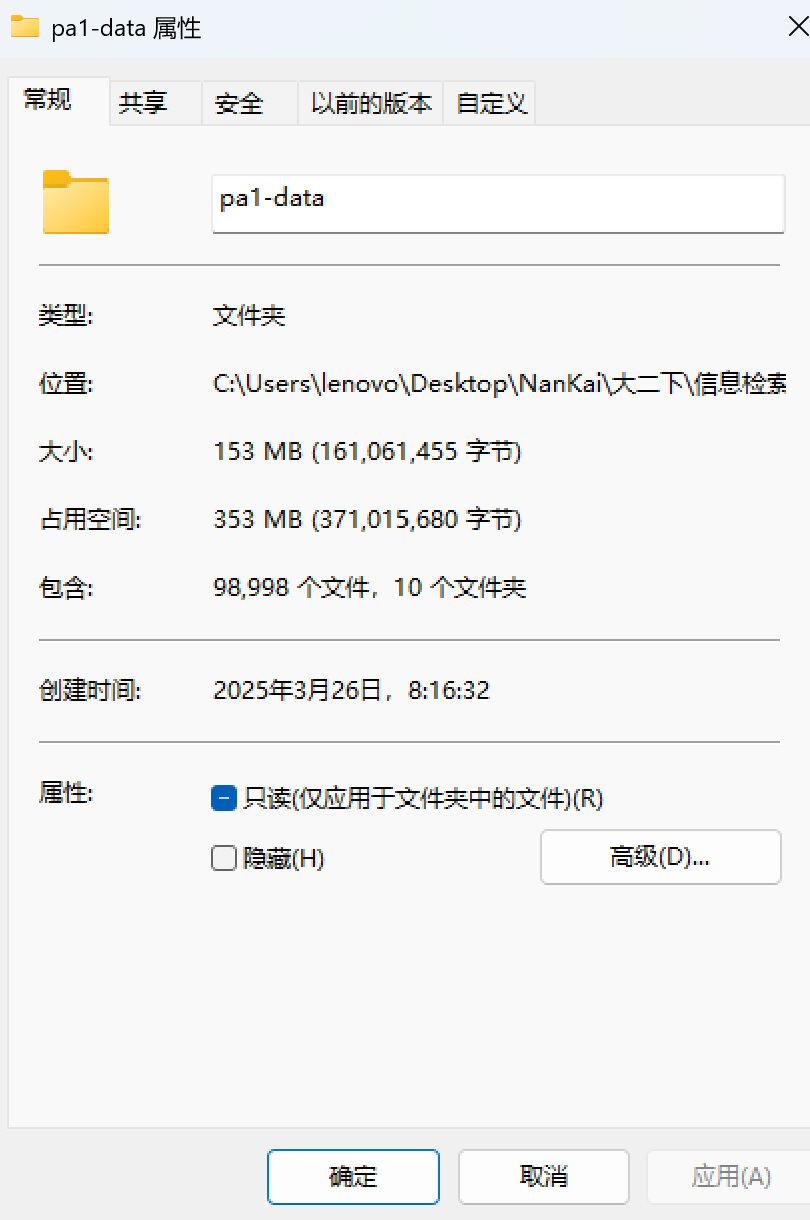
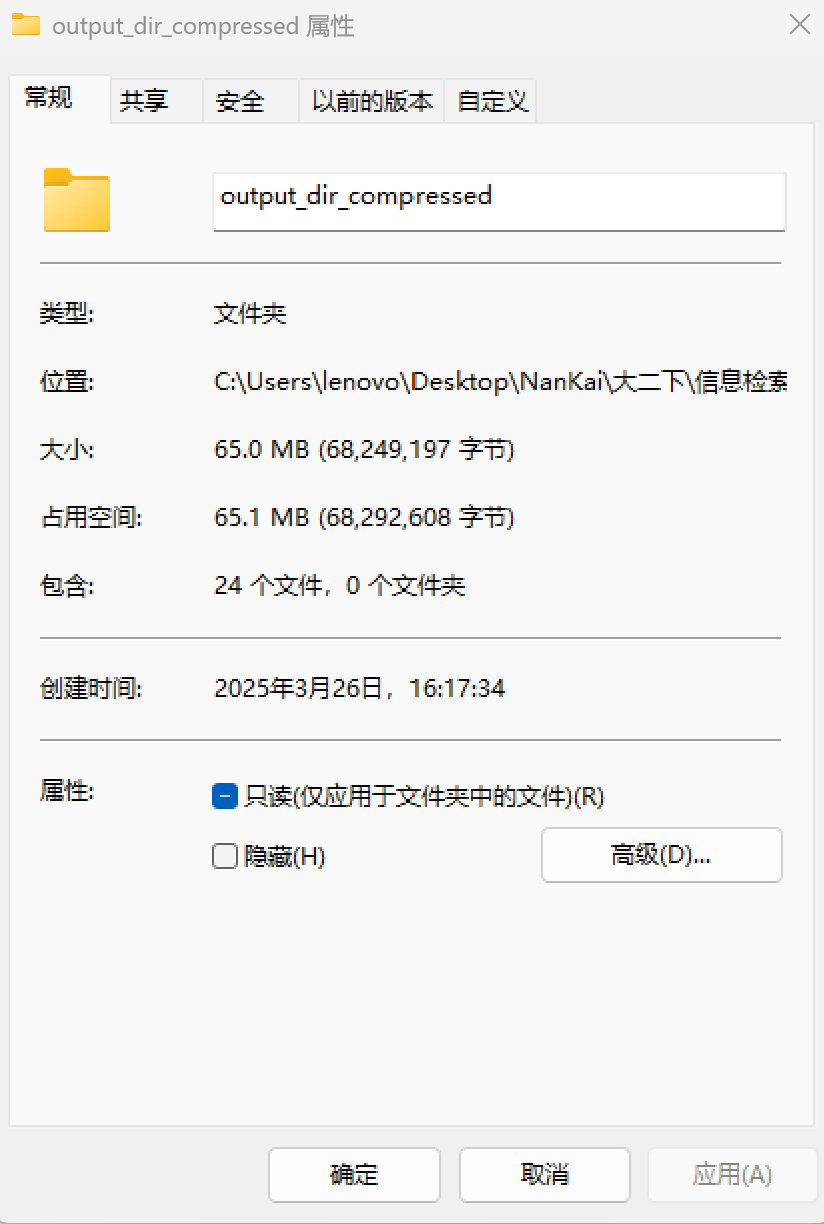

# 额外的编码方式 (10%)

通过补充`ECCompressedPostings`的`encode` 和 `decode`方法来实现一种额外的索引压缩方式。在我们课上学的就是**gamma-encoding** 。另外如果大家感兴趣的话也可以了解**Delta Encoding** ，[ALGORITHM SIMPLE-9](https://github.com/manning/CompressionAlgorithms#simple-9) 等。

你应该以多字节（而不是bits）来存储倒排记录表，因为索引的长度和位置都存的是字节信息。 (4%)

In [84]:
class ECCompressedPostings:
    #If you need any extra helper methods you can add them here 
    ### Begin your code
    @staticmethod
    def varbyte_encode_number(n):
        """使用可变字节编码 (VarByte) 对单个整数进行编码

        Parameters
        ----------
        n : int
            需要编码的整数
        
        Returns
        -------
        List[int]
            编码后的字节列表
        """
        bytes_list = []
        while True:
            bytes_list.insert(0, n % 128)  # 取低7位
            if n < 128:
                break
            n //= 128
        bytes_list[-1] += 128  # 设置最后一个字节的最高位为 1，设置结束标记
        return bytes_list
    @staticmethod
    def varbyte_encode_list(numbers):
        """使用可变字节编码对整数列表进行编码

        Parameters
        ----------
        numbers : List[int]
            需要编码的整数列表
        
        Returns
        -------
        bytes
            编码后的字节流
        """
        bytestream = []
        for number in numbers:
            bytestream.extend(ECCompressedPostings.varbyte_encode_number(number))
        return array.array('B', bytestream).tobytes()

    @staticmethod
    def varbyte_decode(encoded_bytes):
        """使用可变字节编码对字节流进行解码

        Parameters
        ----------
        encoded_bytes : bytes
            编码后的字节流
        
        Returns
        -------
        List[int]
            解码后的整数列表
        """
        numbers = []
        n = 0
        for byte in encoded_bytes:
            if byte < 128:
                n = 128 * n + byte  # 高位为 0，继续累加
            else:
                n = 128 * n + (byte - 128)  # 高位为 1，表示数字结束
                numbers.append(n)
                n = 0   # 必须重置累加器
        return numbers
    ### End your code
    
    @staticmethod
    def encode(postings_list):
        """Encodes `postings_list` 
        
        Parameters
        ----------
        postings_list: List[int]
            The postings list to be encoded
        
        Returns
        -------
        bytes: 
            Bytes reprsentation of the compressed postings list 
        """
        ### Begin your code
        if not postings_list:
            return b''

        # 计算差值（Delta 编码）
        gaps = [postings_list[0]]  # 第一个文档ID直接存储（后续处理相对差值）
        for i in range(1, len(postings_list)):
            # 计算差值，严格依赖输入列表的升序特性
            gaps.append(postings_list[i] - postings_list[i - 1])  

        # 使用 VarByte 编码对差值列表进行压缩
        return ECCompressedPostings.varbyte_encode_list(gaps)
        ### End your code

        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes a byte representation of compressed postings list
        
        Parameters
        ----------
        encoded_postings_list: bytes
            Bytes representation as produced by `CompressedPostings.encode` 
            
        Returns
        -------
        List[int]
            Decoded postings list (each posting is a docId)
        """
        ### Begin your code
        if not encoded_postings_list:
            return []

        # 使用 VarByte 解码差值列表
        gaps = ECCompressedPostings.varbyte_decode(encoded_postings_list)

        # 通过累加差值恢复原始的文档 ID 列表，通过累加差值逆向delta编码
        postings_list = []
        current_doc_id = 0
        for gap in gaps:
            current_doc_id += gap
            postings_list.append(current_doc_id)

        return postings_list
        ### End your code

第一段代码定义了静态方法来实现可变字节编码（VarByte）对整数的编码和解码功能。`varbyte_encode_number` 方法将单个整数编码为字节列表，通过循环取低 7 位并右移整数，直到整数小于 128，最后将最后一个字节的最高位设为 1 作为结束标记。`varbyte_encode_list` 方法对整数列表进行编码，遍历列表中每个整数，调用 `varbyte_encode_number` 方法编码后添加到字节流，再将其转换为 `bytes` 对象。`varbyte_decode` 方法对编码后的字节流解码，通过检查字节最高位判断是否为结束字节，累加字节值得到整数，将完整整数添加到结果列表并重置累加器。此编码方式能根据整数大小动态分配字节，适合需要压缩整数存储的场景，如信息检索系统中倒排索引的文档 ID 列表压缩。 

第二段段代码主要实现了对倒排列表的压缩处理。首先检查传入的倒排列表 `postings_list` 是否为空，若为空则直接返回空字节串 `b''`。若列表不为空，会进行差值（Delta）编码，先将列表的第一个文档 ID 直接存入 `gaps` 列表，后续从第二个元素开始，通过遍历 `postings_list`，计算当前元素与前一个元素的差值并添加到 `gaps` 列表中，此操作严格依赖输入列表为升序排列的特性。完成差值计算后，会调用 `ECCompressedPostings` 类的 `varbyte_encode_list` 方法，使用可变字节（VarByte）编码对 `gaps` 列表进行压缩，并返回压缩后的字节串。整体上，该代码结合了差值编码和可变字节编码，有效减少了倒排列表的存储空间。 

第三段代码实现了对编码后的倒排列表进行解码并恢复为原始文档 ID 列表的功能。首先，它会检查传入的编码后的倒排列表 `encoded_postings_list` 是否为空，若为空则直接返回空列表。若不为空，会调用 `ECCompressedPostings` 类的 `varbyte_decode` 方法，使用可变字节（VarByte）解码方式对 `encoded_postings_list` 进行解码，得到差值列表 `gaps`。接着，代码会通过累加差值的方式逆向还原出原始的文档 ID 列表，具体做法是初始化一个 `current_doc_id` 为 0，然后遍历 `gaps` 列表，将每个差值累加到 `current_doc_id` 上，并把得到的当前文档 ID 添加到 `postings_list` 中。最终，返回恢复后的原始文档 ID 列表。 

同上，写一些测试样例来确保代码正常运行 (3%)

In [85]:
### Begin your code
try: 
    os.mkdir('output_dir_eccompressed')
except FileExistsError:
    pass

BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_eccompressed', postings_encoding=ECCompressedPostings)
BSBI_instance_compressed.index()

BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_eccompressed', postings_encoding=ECCompressedPostings)
BSBI_instance_compressed.retrieve('boolean retrieval')

for i in range(1, 9):
    with open('dev_queries/query.' + str(i)) as q:
        query = q.read()
        my_results = [os.path.normpath(path) for path in BSBI_instance_compressed.retrieve(query)]
        with open('dev_output/' + str(i) + '.out') as o:
            reference_results = [os.path.normpath(x.strip()) for x in o.readlines()]
            assert my_results == reference_results, "Results DO NOT match for query: "+query.strip()
        print("Results match for query:", query.strip())
### End your code

Results match for query: we are
Results match for query: stanford class
Results match for query: stanford students
Results match for query: very cool
Results match for query: the
Results match for query: a
Results match for query: the the
Results match for query: stanford computer science


这段代码主要完成了基于 `ECCompressedPostings` 编码方式的 BSBI 索引构建、检索操作，并对检索结果进行验证。首先，尝试创建名为 `output_dir_eccompressed` 的目录，若目录已存在则忽略 `FileExistsError` 异常。接着，创建 `BSBIIndex` 类的实例 `BSBI_instance_compressed`，指定数据目录为 `pa1-data`，输出目录为 `output_dir_eccompressed`，使用 `ECCompressedPostings` 进行倒排列表的编码，然后调用 `index` 方法构建索引。之后，再次创建相同配置的 `BSBIIndex` 实例，并使用 `retrieve` 方法对查询语句 `'boolean retrieval'` 进行检索。最后，代码循环读取 `dev_queries` 目录下编号为 1 到 8 的查询文件内容，调用 `retrieve` 方法获取查询结果，并对路径进行标准化处理。同时读取 `dev_output` 目录下对应编号的输出文件内容，同样对路径进行标准化处理。通过 `assert` 语句验证检索结果与参考结果是否一致，若一致则打印提示信息，确保系统的检索结果符合预期。 

请追加压缩前后的文件大小截图 (3%)

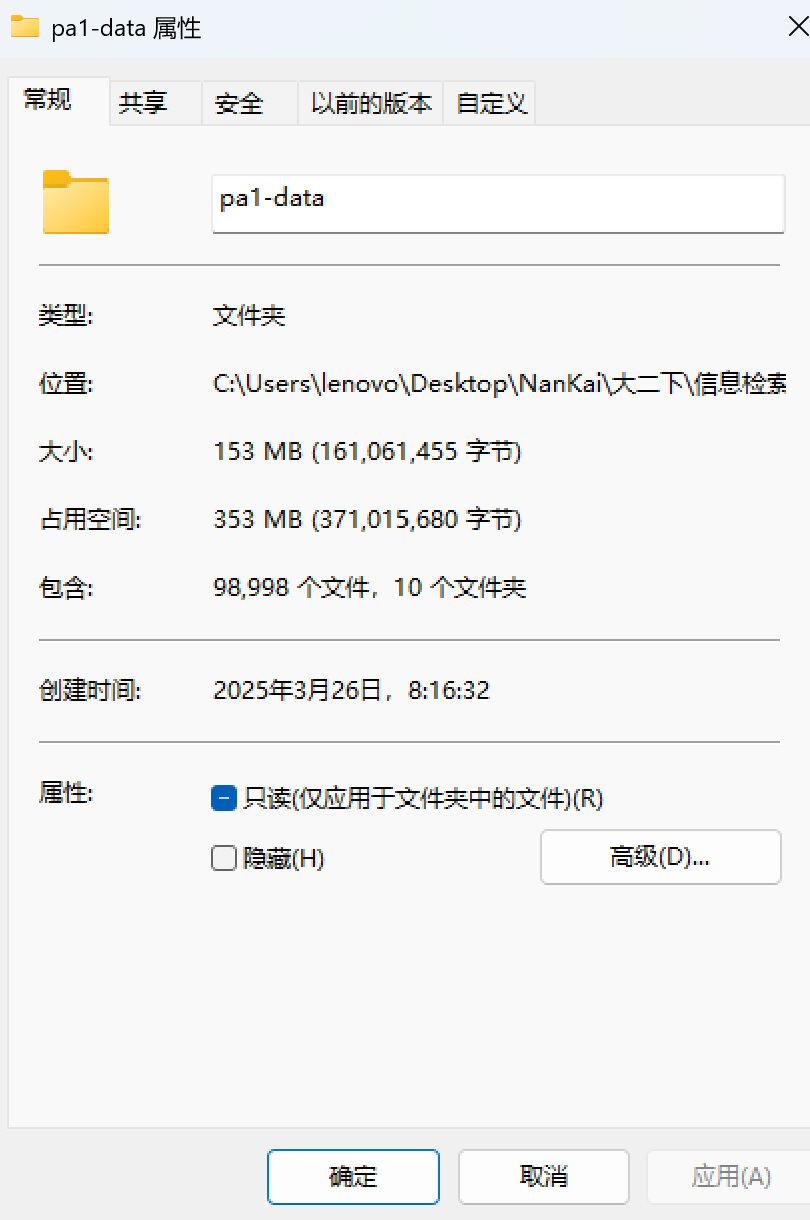
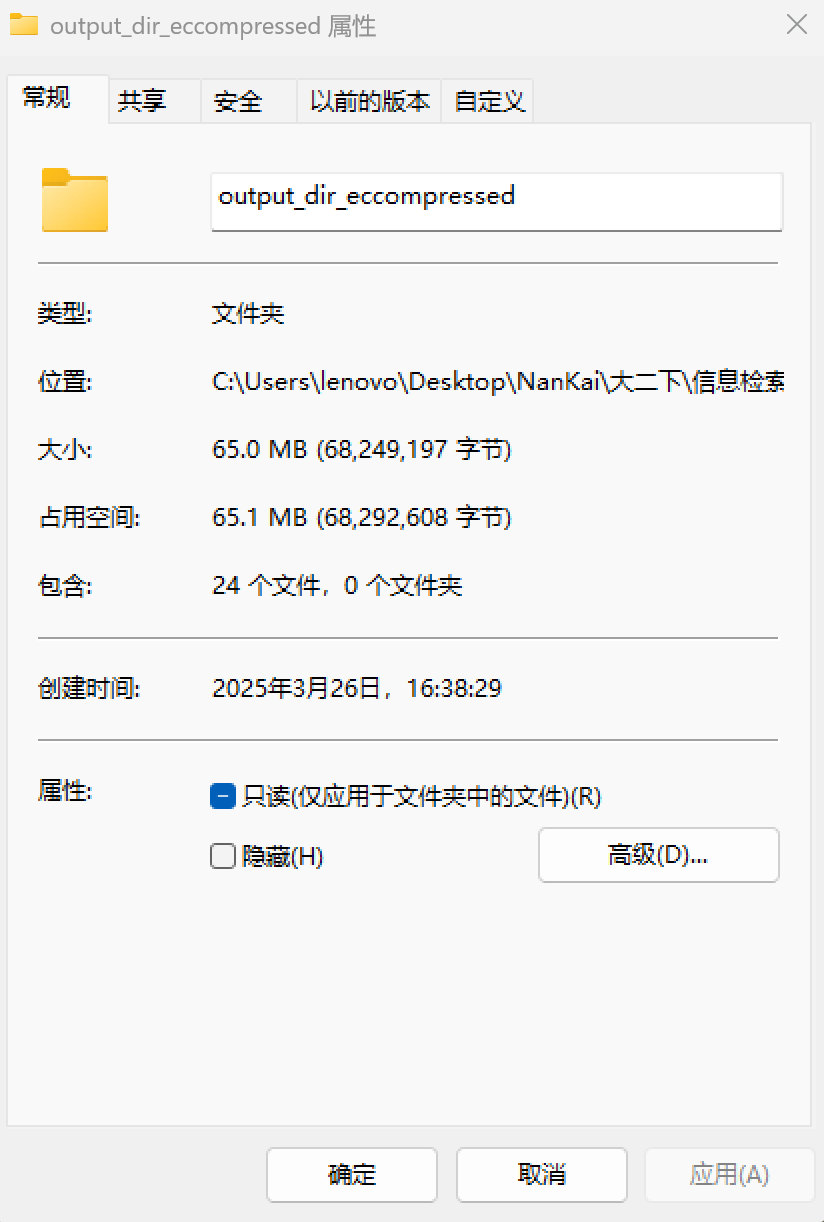

# 作业提交

本次作业用时约3周，截止日期为2024.03.26。请大家在截止日期前将代码、实验报告（可单独撰写，也可整合在jupyter notebook中）一起提交到ir24fall@163.com，邮件和文件命名方式均为`学号_姓名_hw1`，如`1811412_戚晓睿_hw1.ipynb`